In [2]:
#Similar Players by Metrics

from nba_api.stats.endpoints import PlayerEstimatedMetrics, CommonPlayerInfo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import timeas

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Select relevant columns (metrics only)
metrics_columns = [
    "PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
    "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_TOV_PCT", "E_USG_PCT"
]

# Clean the data (drop rows with missing values)
metrics_data = metrics_data[metrics_columns].dropna()

# Filter for players who play at least 35 minutes per game
metrics_data = metrics_data[metrics_data["MIN"] >= 35].reset_index(drop=True)  # Reset index after filtering

# Function to get player position and assign dummy code
def get_position_code(player_id):
    position_mapping = {
        "Guard": 1.5,
        "Guard-Forward": 3,
        "Forward": 4,
        "Forward-Center": 4.5,
        "Center": 5
    }
    
    try:
        player_info = CommonPlayerInfo(player_id=player_id).get_data_frames()[0]
        position = player_info.loc[0, "POSITION"]
        return position_mapping.get(position, 3)  # Default to 3 if position is unknown
    except:
        return 3  # Default category

# Apply the function to get position codes (with a delay to avoid rate limits)
position_codes = []
for pid in metrics_data["PLAYER_ID"]:
    position_codes.append(get_position_code(pid))
    time.sleep(0.6)  # Prevent hitting API rate limits

# Add position codes to the dataframe
metrics_data["POSITION_CODE"] = position_codes

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(metrics_data.iloc[:, 3:])  # Exclude PLAYER_ID, MIN, and PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."

    distances, indices = model.kneighbors([scaled_features[idx[0]]])  # Ensure indices are correctly mapped
    similar_players = data.iloc[indices[0]]["PLAYER_NAME"].tolist()

    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Jalen Brunson"  # Change to any player
similar_players = find_similar_players(player_name, metrics_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")


Players similar to Jalen Brunson: ['Jalen Brunson', 'Damian Lillard', 'Devin Booker', "De'Aaron Fox", 'Tyrese Maxey', 'Kyrie Irving', 'Jamal Murray', 'Tyler Herro', 'DeMar DeRozan', 'Trae Young', 'Anthony Edwards', 'Mikal Bridges', 'Cade Cunningham', 'Kevin Durant', 'Jaylen Brown']


In [92]:
# Similar Players By Metrics and Per Game Stats

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."
    
    distances, indices = model.kneighbors([scaled_features[idx[0]]])
    similar_players = data.iloc[indices[0], :]["PLAYER_NAME"].tolist()
    
    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Giannis Antetokounmpo"  # Change to any player
similar_players = find_similar_players(player_name, merged_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")


Players similar to Giannis Antetokounmpo: ['Giannis Antetokounmpo', 'Alperen Sengun', 'Anthony Davis', 'Joel Embiid', 'Zion Williamson', 'Karl-Anthony Towns', 'Jalen Johnson', 'Evan Mobley', 'Paolo Banchero', 'Bam Adebayo', 'Scottie Barnes', 'Ivica Zubac', 'Domantas Sabonis', 'Nikola Vučević', 'LeBron James']


In [234]:
# Similar Players By Shooting & Defense

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "E_OFF_RATING", "E_DEF_RATING", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG3A", "GP", "PTS", "STL", "BLK"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."
    
    distances, indices = model.kneighbors([scaled_features[idx[0]]])
    similar_players = data.iloc[indices[0], :]["PLAYER_NAME"].tolist()
    
    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Derrick White"  # Change to any player
similar_players = find_similar_players(player_name, merged_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")

Players similar to Derrick White: ['Derrick White', 'Naz Reid', 'Tyrese Haliburton', 'Klay Thompson', 'OG Anunoby', 'Mikal Bridges', 'Keegan Murray', 'James Harden', 'Michael Porter Jr.', 'Payton Pritchard', 'Jalen Green', 'Stephen Curry', 'Buddy Hield', 'Trey Murphy III', 'Austin Reaves']


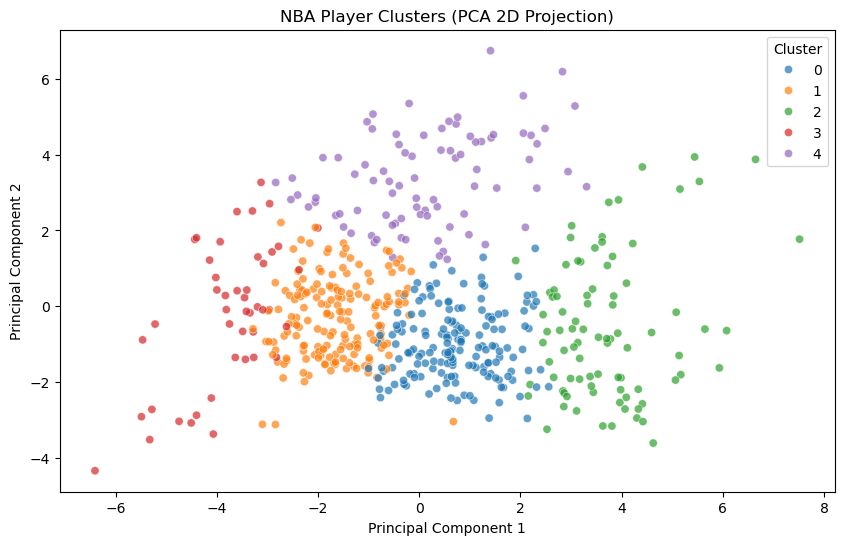

        PLAYER_NAME  Cluster
0    Jamaree Bouyea        1
1     James Wiseman        1
2    Tristen Newton        3
3      Jack McVeigh        1
4      N'Faly Dante        4
..              ...      ...
554  Ulrich Chomche        3
555   Justin Minaya        3
556  Daniss Jenkins        3
557     Zyon Pullin        3
558     P.J. Tucker        1

[559 rows x 2 columns]


In [192]:
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least x minutes per game
#merged_data = merged_data[merged_data["MIN"] >= 15]

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply K-Means clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Convert PCA results into a DataFrame
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = merged_data["Cluster"]
pca_df["PLAYER_NAME"] = merged_data["PLAYER_NAME"]

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7)
plt.title("NBA Player Clusters (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Display cluster assignments
print(merged_data[["PLAYER_NAME", "Cluster"]])


         PLAYER_NAME  PLAYER_ID
0          Ja Morant    1629630
1      Jalen Johnson    1630552
2       Santi Aldama    1630583
3   Taylor Hendricks    1641707
4  Scotty Pippen Jr.    1630590

PCA Loadings (How each stat contributes to PC1 and PC2):
                   PC1       PC2
MIN           0.019286  0.409306
E_OFF_RATING  0.031684  0.281629
E_DEF_RATING -0.045281 -0.123204
E_NET_RATING  0.046859  0.260702
E_AST_RATIO  -0.072155  0.077751
E_OREB_PCT    0.390166 -0.101537
E_DREB_PCT    0.390295  0.072414
E_REB_PCT     0.419201  0.016476
E_TOV_PCT     0.140674 -0.057016
E_USG_PCT     0.002793  0.362753
FG3M         -0.243501  0.272185
FG3_PCT      -0.273306  0.134272
FG_PCT        0.329879  0.061449
PPG           0.032809  0.441684
RPG           0.389467  0.157259
BPG           0.299874  0.052911
SPG          -0.034738  0.257734
APG          -0.048835  0.358282


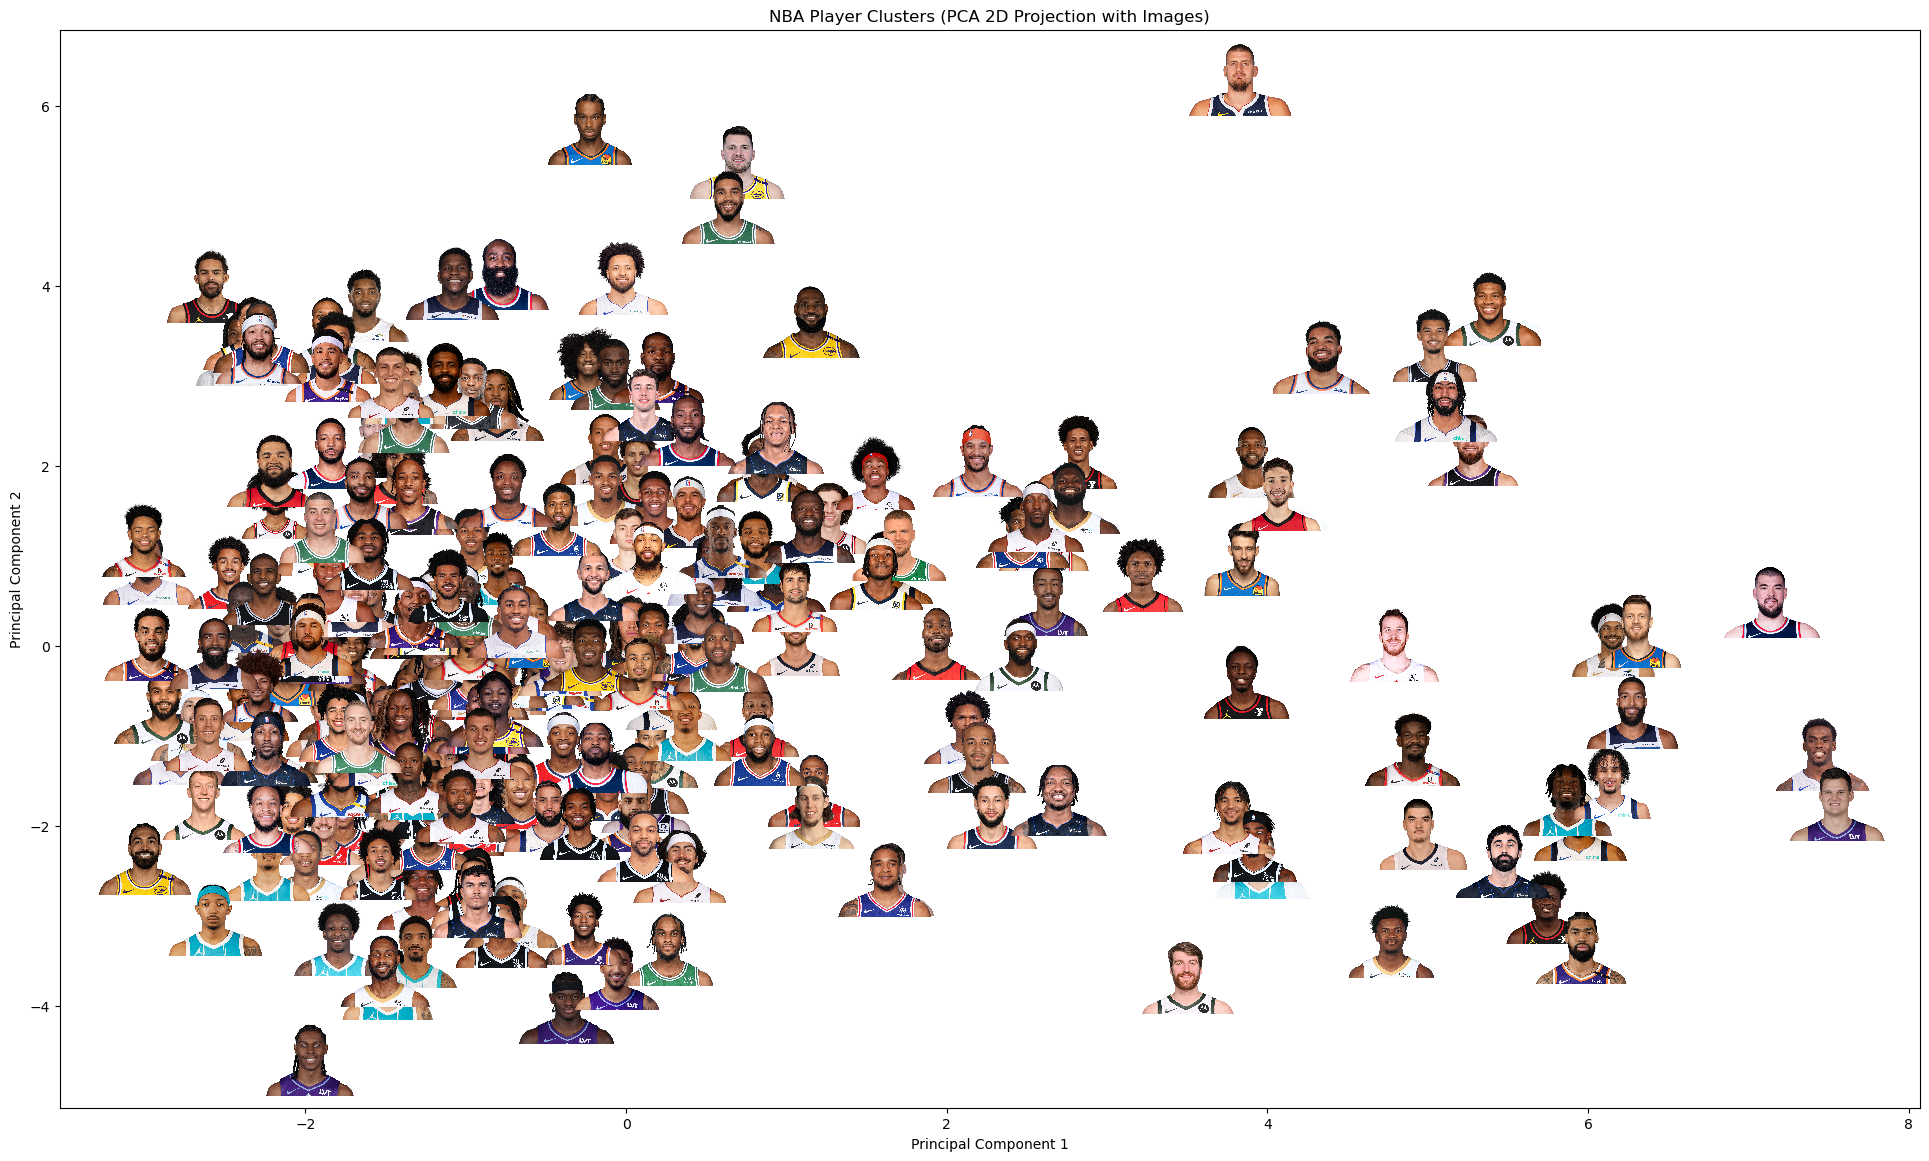

                  PLAYER_NAME  Cluster
254             Jaylen Nowell        0
191            Justin Edwards        0
27            Bilal Coulibaly        0
180            Nick Smith Jr.        0
31             Bub Carrington        0
67            Malcolm Brogdon        0
34              Cody Williams        0
167               Bruce Brown        0
37                 Kyle Kuzma        0
155            Ja'Kobe Walter        0
198                KJ Simpson        0
150            Brandon Boston        0
147                Josh Green        0
137            Oshae Brissett        0
131              Terance Mann        0
49             Kyshawn George        0
253           Tosan Evbuomwan        0
113                 KJ Martin        0
95             Jordan Hawkins        0
70             Keldon Johnson        0
61            Kyle Filipowski        0
41              Corey Kispert        0
199              Keon Johnson        0
65               Ochai Agbaji        0
204               Chuma O

In [18]:
# K Means Clustering

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.offsetbox as offsetbox
from io import BytesIO
import requests
import time  # For rate-limiting

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least 20 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns (keeping only per-game stats)
merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])

# Drop non-numeric columns before scaling
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)

# Recreate the DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=merged_data_numerical.columns)

# Apply K-Means clustering
num_clusters = 8  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Convert PCA results into a DataFrame and align with original indices
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"], index=merged_data.index)

# Ensure proper merging of player info
pca_df = pd.concat([pca_df, merged_data[["PLAYER_NAME", "PLAYER_ID", "Cluster"]]], axis=1)

# Debug: Check if PLAYER_NAME and PLAYER_ID are now present
print(pca_df[["PLAYER_NAME", "PLAYER_ID"]].head())

# Get PCA loadings to interpret principal components
pca_loadings = pd.DataFrame(pca.components_.T, index=merged_data_numerical.columns, columns=["PC1", "PC2"])
print("\nPCA Loadings (How each stat contributes to PC1 and PC2):")
print(pca_loadings)

# Function to fetch player image URL
def get_player_image(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png"

# Plot PCA clusters with player images
plt.figure(figsize=(24, 14))  # Increased figure size
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7, legend=False)

# Add player images to the scatter plot
ax = plt.gca()
for i, row in pca_df.iterrows():
    player_id = int(row["PLAYER_ID"])  # Ensure ID is properly formatted
    image_url = get_player_image(player_id)

    try:
        img_response = requests.get(image_url)
        img = plt.imread(BytesIO(img_response.content))
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=0.07), (row["PC1"], row["PC2"]), frameon=False)  # Adjusted image size
        ax.add_artist(imagebox)
    except Exception as e:
        print(f"Error fetching image for {row['PLAYER_NAME']} (ID: {player_id}): {e}")

# Set plot titles and labels
plt.title("NBA Player Clusters (PCA 2D Projection with Images)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Sort by Cluster
ordered_df = merged_data[["PLAYER_NAME", "Cluster"]].sort_values(by="Cluster")

# Display sorted DataFrame with only PLAYER_NAME and Cluster
pd.set_option('display.max_rows', None)  # Show all rows
print(ordered_df)



PCA Loadings (How each stat contributes to PC1 and PC2):
                   PC1       PC2
MIN          -0.116657  0.298603
E_OFF_RATING -0.023370  0.343548
E_DEF_RATING -0.100220 -0.142243
E_NET_RATING  0.041726  0.322149
E_AST_RATIO  -0.119060  0.256016
E_OREB_PCT    0.391479  0.011978
E_DREB_PCT    0.352983  0.195381
E_REB_PCT     0.391040  0.150391
E_TOV_PCT     0.128048  0.072909
E_USG_PCT    -0.110441  0.335243
FG3M         -0.296926  0.131806
FG3_PCT      -0.247360  0.062635
FG_PCT        0.308924  0.127328
PPG          -0.109500  0.410045
RPG           0.374389  0.192223
BPG           0.268809  0.015917
SPG          -0.082955  0.166772
APG          -0.156340  0.392370


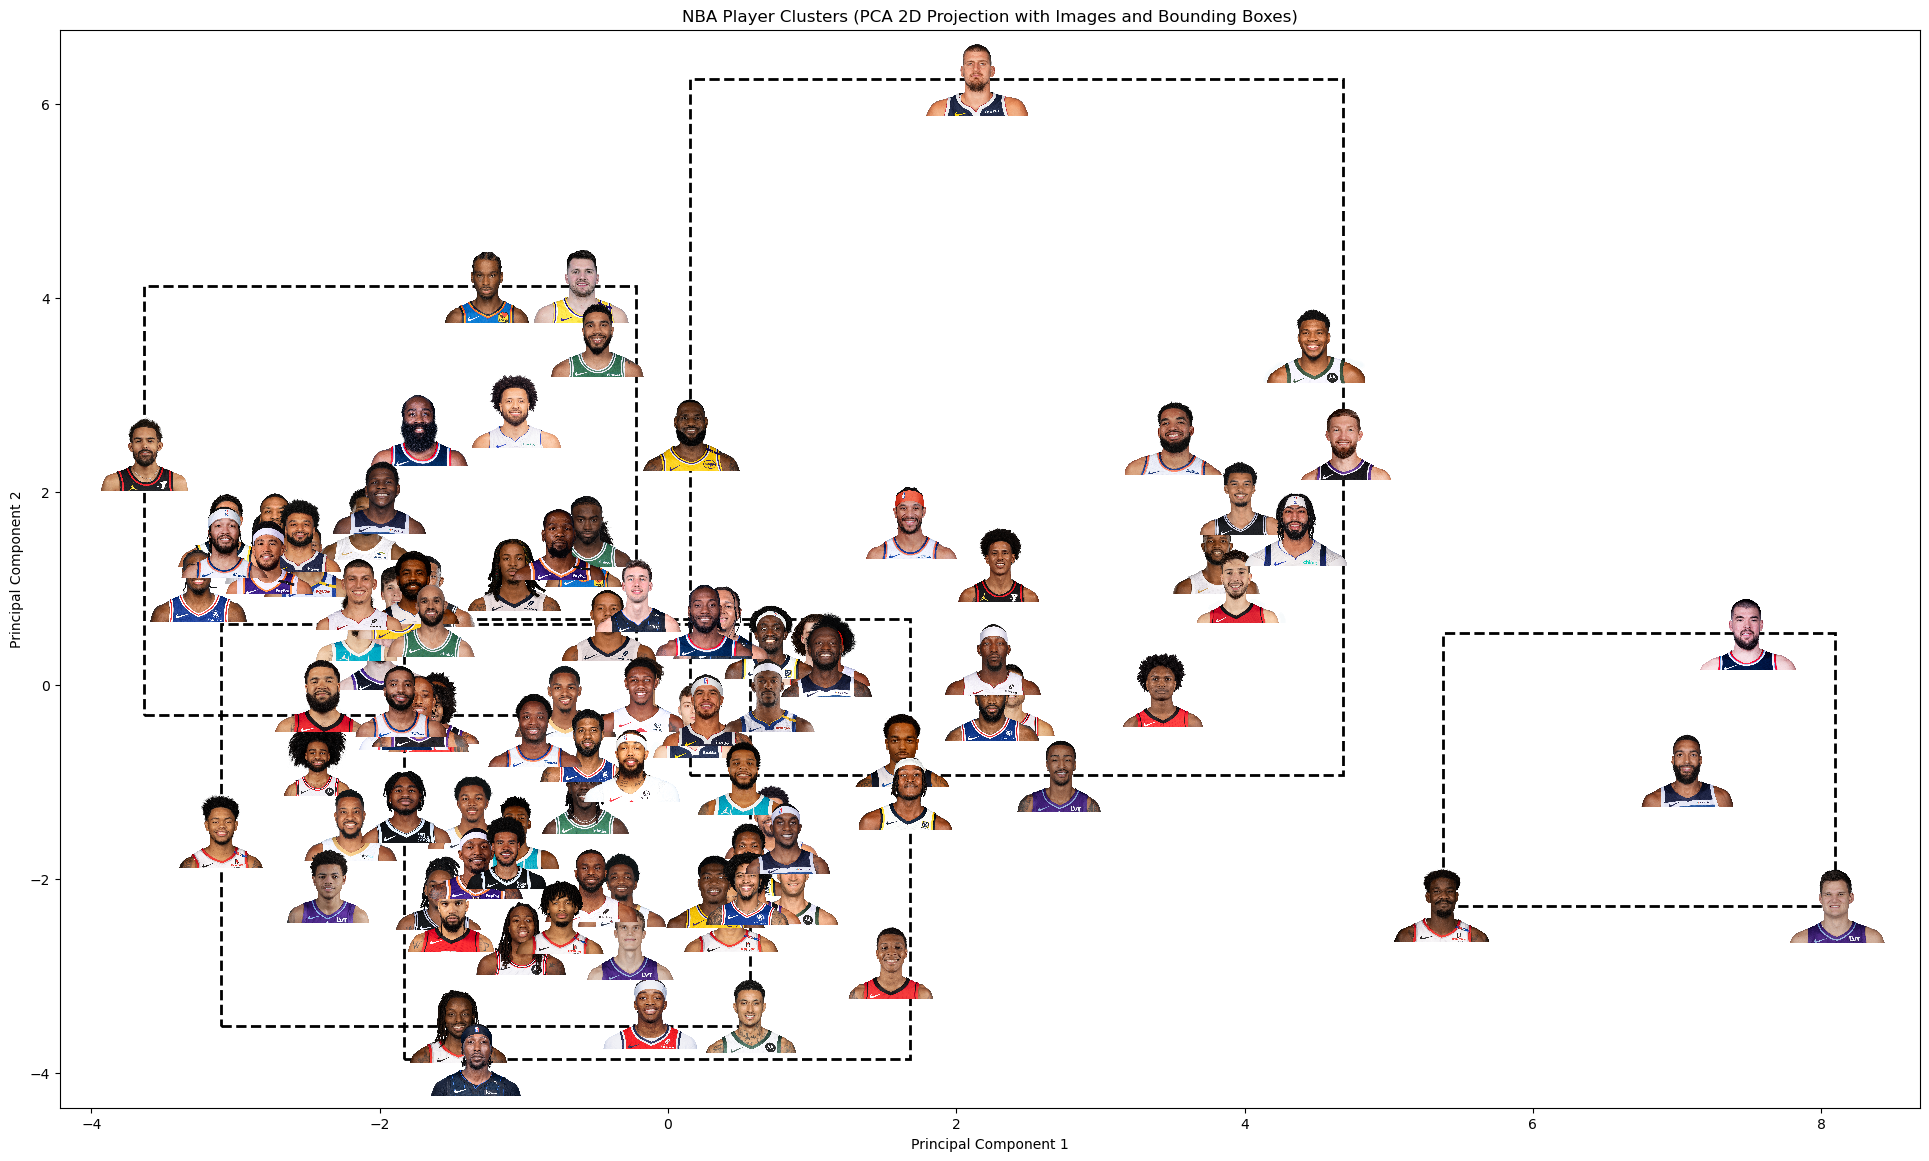

                  PLAYER_NAME  Cluster
0                   Ja Morant        0
20              Stephen Curry        0
22               De'Aaron Fox        0
45               Jamal Murray        0
76               Kevin Durant        0
25           Donovan Mitchell        0
74               Jaylen Brown        0
72               James Harden        0
69              Fred VanVleet        0
62              DeMar DeRozan        0
34                 Malik Monk        0
55               Kyrie Irving        0
37             Damian Lillard        0
52              Austin Reaves        0
49                Luka Dončić        0
43          Tyrese Haliburton        0
80            Anthony Edwards        0
18    Shai Gilgeous-Alexander        0
78               Jayson Tatum        0
16             Jalen Williams        0
99                Tyler Herro        0
2                  Trae Young        0
3                Desmond Bane        0
93              Jalen Brunson        0
17            Cade Cunnin

In [24]:
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.offsetbox as offsetbox
from matplotlib import patches
from io import BytesIO
import requests

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID and reset index
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID", how="inner").reset_index(drop=True)

# Filter for players who play at least 30 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 30].copy()

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])

# Drop non-numeric columns before scaling
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)

# Recreate the DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=merged_data_numerical.columns)

# Apply K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Convert PCA results into a DataFrame
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = merged_data["Cluster"].values
pca_df["PLAYER_NAME"] = merged_data["PLAYER_NAME"].values
pca_df["PLAYER_ID"] = merged_data["PLAYER_ID"].values

# Get PCA loadings
top_pca_loadings = pd.DataFrame(pca.components_.T, index=merged_data_numerical.columns, columns=["PC1", "PC2"])
print("\nPCA Loadings (How each stat contributes to PC1 and PC2):")
print(top_pca_loadings)

# Function to fetch player image URL
def get_player_image(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png"

# Plot PCA clusters with player images and bounding boxes
plt.figure(figsize=(24, 14))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7, legend=False)

# Add player images
ax = plt.gca()
for _, row in pca_df.iterrows():
    player_id = row["PLAYER_ID"]
    image_url = get_player_image(player_id)
    try:
        img_response = requests.get(image_url)
        img = plt.imread(BytesIO(img_response.content))
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=0.07), (row["PC1"], row["PC2"]), frameon=False)
        ax.add_artist(imagebox)
    except Exception as e:
        print(f"Error fetching image for {row['PLAYER_NAME']}: {e}")

# Add bounding boxes around each cluster
for cluster_id in range(num_clusters):
    cluster_data = pca_df[pca_df["Cluster"] == cluster_id]
    x_min, x_max = cluster_data["PC1"].min(), cluster_data["PC1"].max()
    y_min, y_max = cluster_data["PC2"].min(), cluster_data["PC2"].max()
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="black", facecolor="none", linestyle="--")
    ax.add_patch(rect)

# Set plot titles and labels
plt.title("NBA Player Clusters (PCA 2D Projection with Images and Bounding Boxes)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Display cluster assignments
#print(pca_df[["PLAYER_NAME", "Cluster"]])

# Display cluster assignments sorted by cluster
print(pca_df[["PLAYER_NAME", "Cluster"]].sort_values("Cluster"))



In [52]:
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import time  # For rate-limiting
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least 20 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns (keeping only per-game stats)
merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])

# Drop non-numeric columns before scaling
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

# Drop non-numeric columns before scaling
#merged_data_numerical = merged_data.select_dtypes(include=['number'])

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)

# Apply K-Means clustering
num_clusters = 8  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data_numerical["Cluster"] = kmeans.fit_predict(scaled_features)

# Cluster profile description: Calculate the mean for each feature by cluster
cluster_summary = merged_data_numerical.groupby("Cluster").mean()
print("\nCluster Summary (Average values of features per cluster):")
print(cluster_summary)


# Describe the main defining factors for each cluster
print("\nDefining factors for each cluster based on feature averages:")
for cluster_num in range(num_clusters):
    cluster_features = cluster_summary.loc[cluster_num]
    print(f"\nCluster {cluster_num}:")
    for feature in cluster_features.index:
        if cluster_features[feature] > cluster_summary[feature].mean():
            print(f"  - {feature} is above average")
        else:
            print(f"  - {feature} is below average")
            
# Merge the cluster column back to the original data to include PLAYER_NAME
merged_data["Cluster"] = merged_data_numerical["Cluster"]

# Sort by Cluster and display player names along with clusters
ordered_df = merged_data[["PLAYER_NAME", "Cluster"]].sort_values(by="Cluster")

# Display sorted DataFrame with only PLAYER_NAME and Cluster
pd.set_option('display.max_rows', None)  # Show all rows
print(ordered_df)


Cluster Summary (Average values of features per cluster):
               MIN  E_OFF_RATING  E_DEF_RATING  E_NET_RATING  E_AST_RATIO  \
Cluster                                                                     
0        24.400000    105.651220    115.275610     -9.629268    16.185366   
1        25.566667    111.055556    109.922222      1.136111    28.261111   
2        33.025000    113.385000    111.165000      2.210000    19.865000   
3        25.052381    114.759524    110.616667      4.142857    16.276190   
4        30.877143    109.108571    114.674286     -5.582857    17.068571   
5        34.497059    115.273529    111.185294      4.097059    21.061765   
6        25.959091    110.368182    112.163636     -1.790909    15.836364   
7        30.356000    114.812000    109.932000      4.872000    13.724000   

         E_OREB_PCT  E_DREB_PCT  E_REB_PCT  E_TOV_PCT  E_USG_PCT        FG3M  \
Cluster                                                                        
0         


Cluster Summary (Average values per cluster, in original scale):
               MIN  E_OFF_RATING  E_DEF_RATING  E_NET_RATING  E_AST_RATIO  \
Cluster                                                                     
0        25.262500    114.514583    109.806250      4.710417    16.956250   
1        31.273913    114.443478    110.130435      4.304348    12.534783   
2        26.246154    112.092308    111.453846      0.646154    16.661538   
3        32.911111    116.611111    109.855556      6.744444    17.511111   
4        34.490909    115.181818    111.339394      3.848485    21.648485   
5        24.265789    105.328947    114.810526     -9.489474    16.084211   
6        30.982759    108.796552    114.906897     -6.127586    16.437931   
7        24.817391    110.826087    111.569565     -0.743478    31.647826   
8        31.104545    111.218182    111.231818     -0.018182    22.009091   
9        25.541176    109.676471    114.164706     -4.488235    16.247059   

         

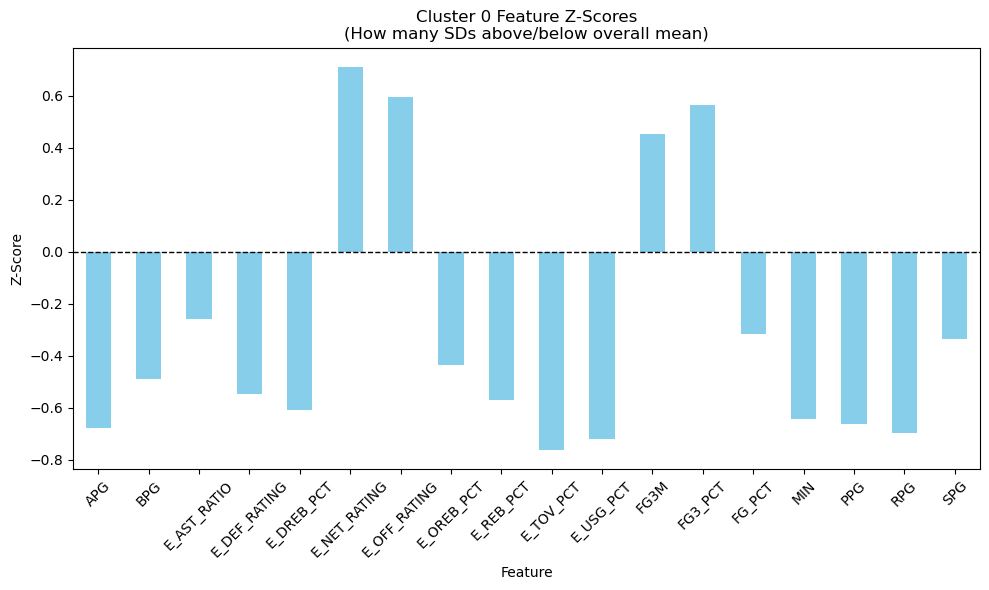

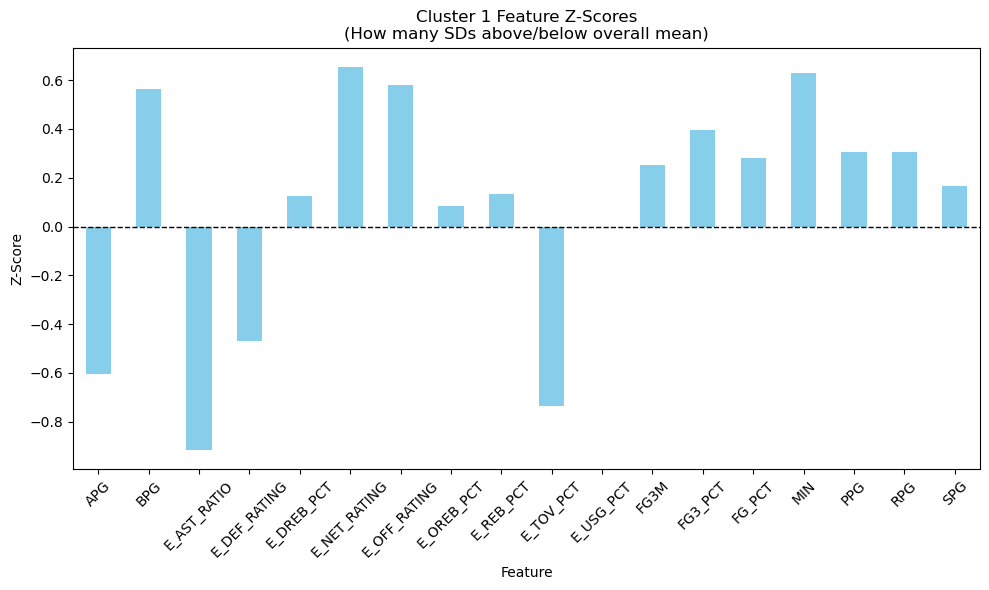

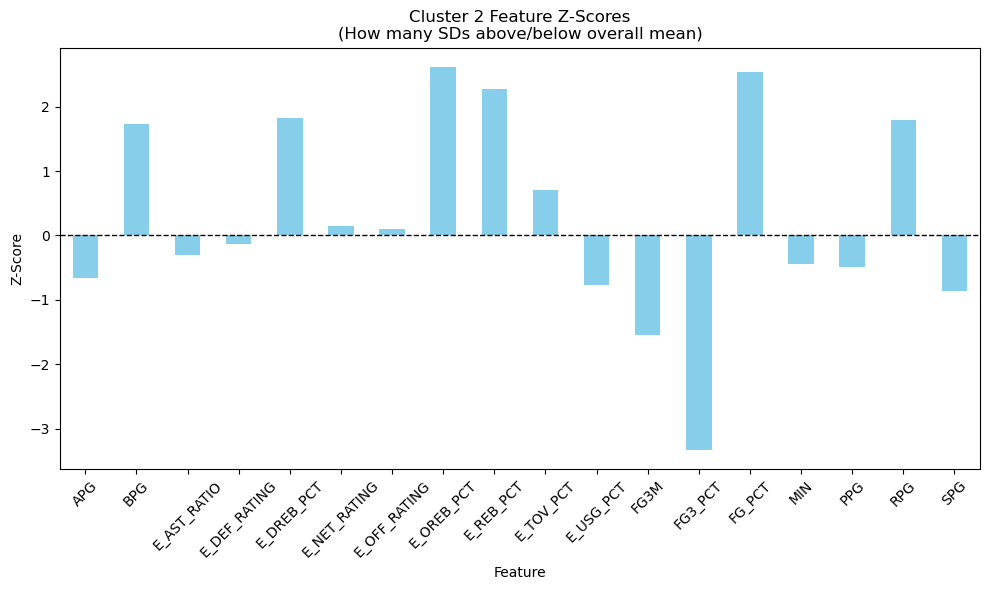

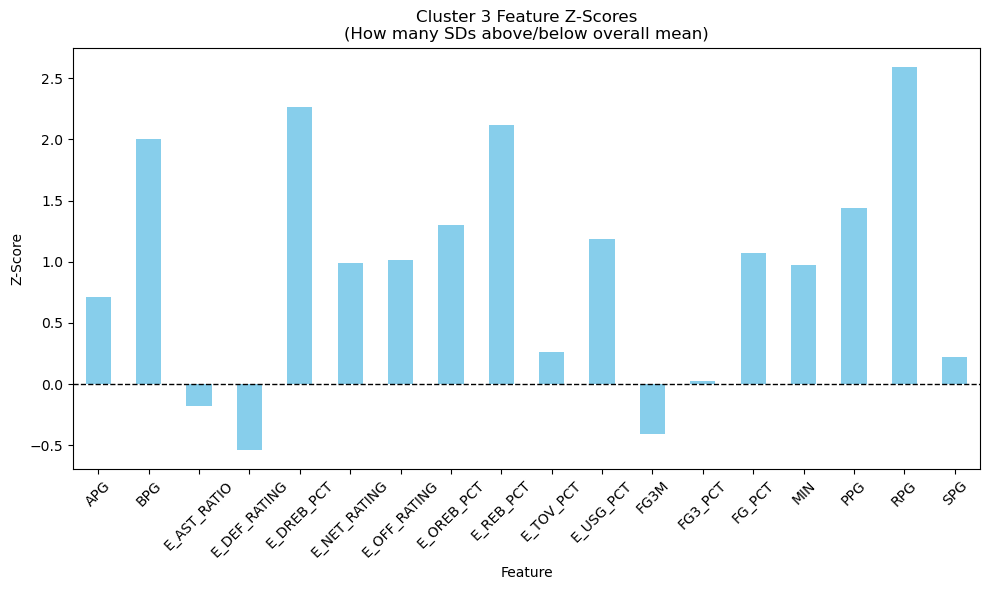

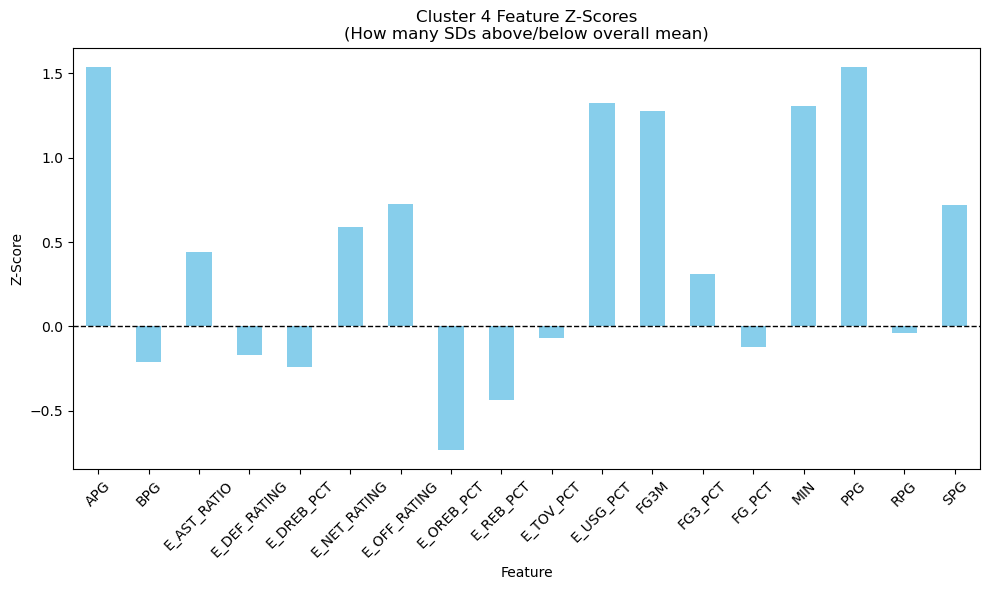

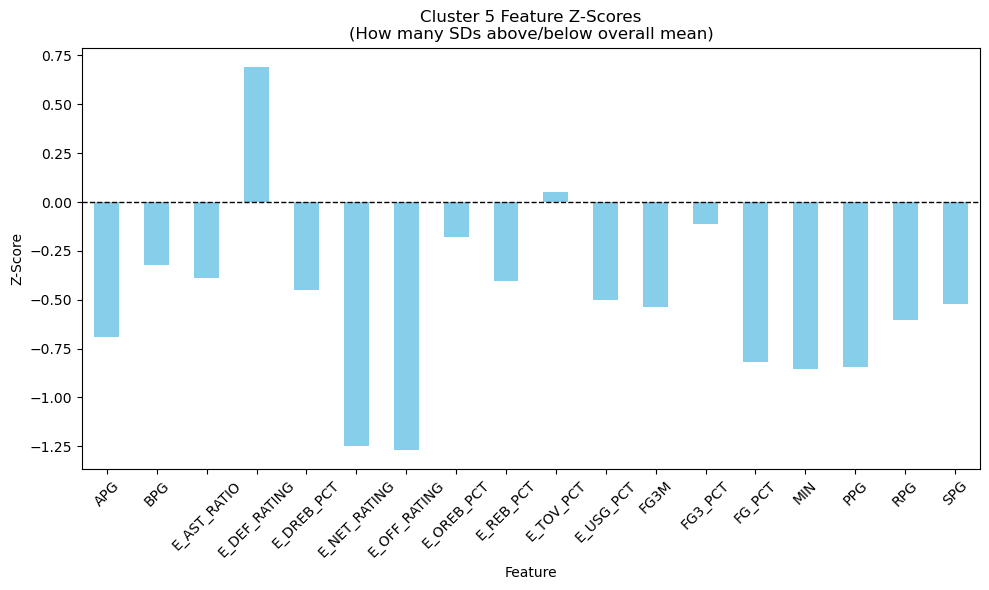

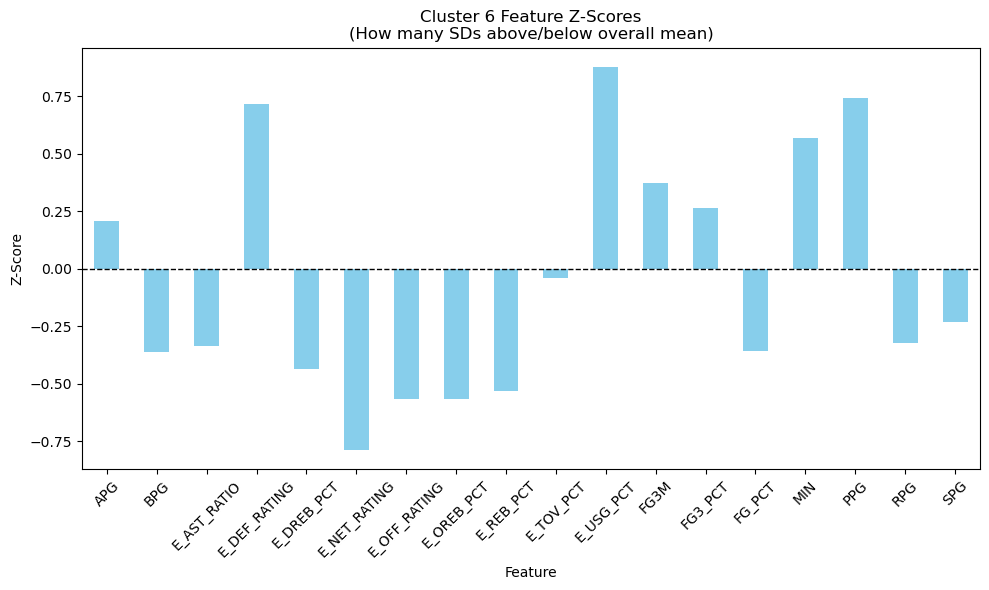

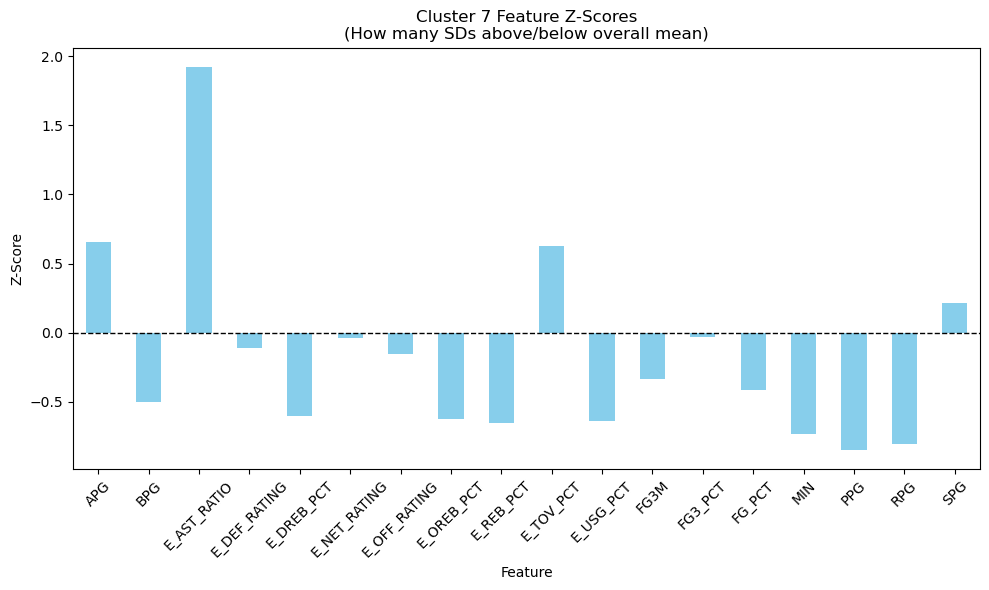

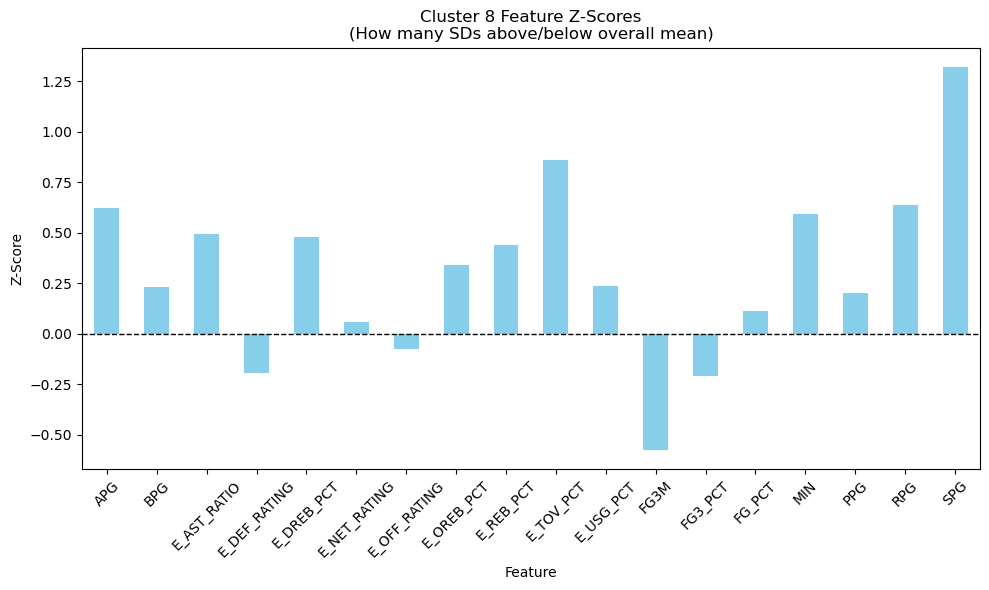

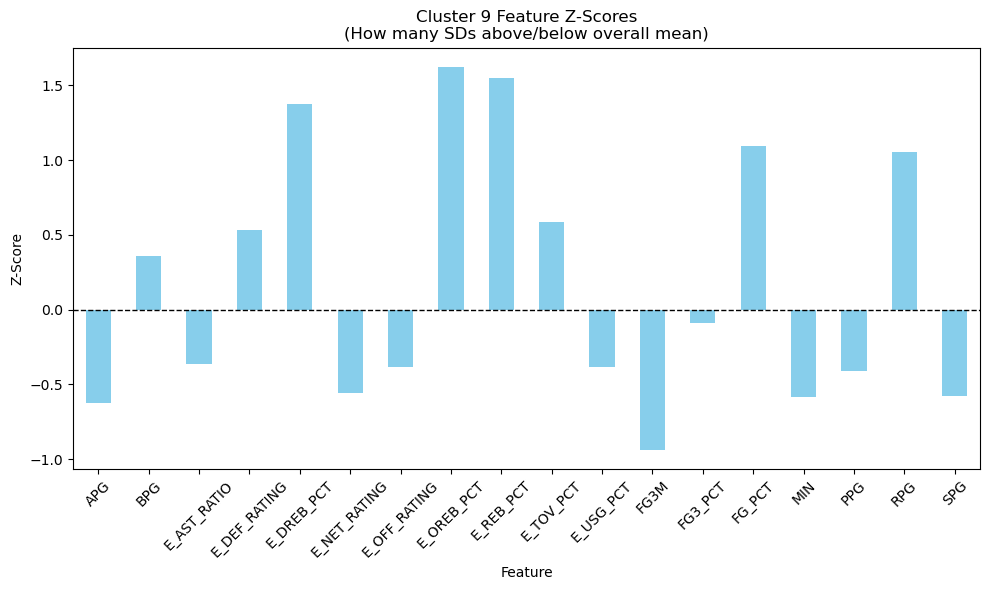

                  PLAYER_NAME  Cluster
127          Donte DiVincenzo        0
40                  Max Strus        0
42           Julian Strawther        0
183                Keon Ellis        0
179             Miles McBride        0
176              Gabe Vincent        0
52               Aaron Gordon        0
171              Jrue Holiday        0
57              Kevin Huerter        0
58              Luguentz Dort        0
165              Max Christie        0
164         Derrick Jones Jr.        0
161            Gary Trent Jr.        0
63              Georges Niang        0
64          Julian Champagnie        0
189             Grayson Allen        0
160           Harrison Barnes        0
151             Klay Thompson        0
74          Bogdan Bogdanović        0
77              Aaron Nesmith        0
141               Moses Moody        0
138        Brandin Podziemski        0
86                 Isaiah Joe        0
134             Dillon Brooks        0
88              Aaron Wig

In [70]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats

# ------------------------------
# Data Fetching and Preprocessing
# ------------------------------

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least 20 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns (keeping only per-game stats)
# Note: We keep PLAYER_NAME here for later use.
merged_data_numerical = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])

# ------------------------------
# Clustering on Numeric Data
# ------------------------------

# Create a DataFrame for clustering by removing the non-numeric column PLAYER_NAME.
cluster_df = merged_data_numerical.drop(columns=["PLAYER_NAME"])

# Standardize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

# Apply K-Means clustering
num_clusters = 10  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data_numerical["Cluster"] = kmeans.fit_predict(scaled_features)

# (Optional) Print cluster summary on the standardized scale:
# Ensure we only include numeric columns before applying the groupby mean
numeric_columns = merged_data_numerical.select_dtypes(include=[np.number]).columns
cluster_summary = merged_data_numerical[numeric_columns].groupby("Cluster").mean()

# Display the result
print("\nCluster Summary (Average values per cluster, in original scale):")
print(cluster_summary)


# ------------------------------
# Calculating and Plotting Z-Scores per Cluster
# ------------------------------

# We'll now compare the cluster-specific means (in the original scale) to the overall means.
# We first define the list of numeric stat columns that we want to analyze.
# (Exclude PLAYER_NAME and Cluster columns.)
analysis_columns = merged_data_numerical.columns.difference(["PLAYER_NAME", "Cluster"])

# Calculate the overall mean and standard deviation for each stat for players with 20+ MPG
overall_means = merged_data_numerical[analysis_columns].mean()
overall_stds  = merged_data_numerical[analysis_columns].std()

# For each cluster, calculate the mean for each stat and compute the z-score:
for cluster_num in range(num_clusters):
    cluster_data = merged_data_numerical[merged_data_numerical["Cluster"] == cluster_num]
    cluster_means = cluster_data[analysis_columns].mean()
    # Calculate Z-scores: (cluster mean - overall mean) / overall standard deviation
    cluster_z_scores = (cluster_means - overall_means) / overall_stds
    
    # Plot a bar chart for this cluster's Z-scores
    plt.figure(figsize=(10, 6))
    cluster_z_scores.plot(kind="bar", color="skyblue")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Cluster {cluster_num} Feature Z-Scores\n(How many SDs above/below overall mean)")
    plt.xlabel("Feature")
    plt.ylabel("Z-Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ------------------------------
# Display Player Names by Cluster
# ------------------------------

# Now merge back the cluster label into the original merged_data for player names
merged_data["Cluster"] = merged_data_numerical["Cluster"]

# Sort by Cluster and display PLAYER_NAME with their Cluster
ordered_df = merged_data[["PLAYER_NAME", "Cluster"]].sort_values(by="Cluster")
pd.set_option('display.max_rows', None)  # Show all rows
print(ordered_df)


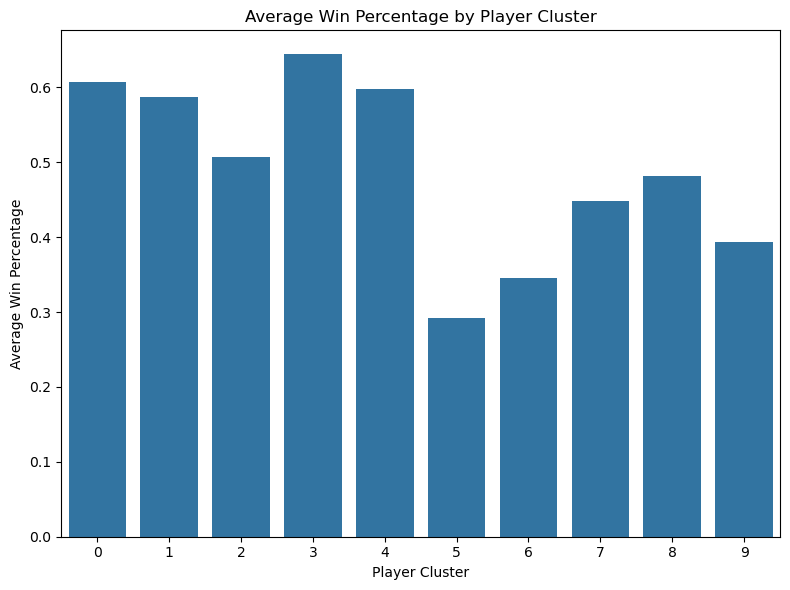

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import LeagueDashPlayerStats

# Fetch LeagueDashPlayerStats
league_stats = LeagueDashPlayerStats()

# Convert the data into a pandas DataFrame
league_stats_df = league_stats.get_data_frames()[0]

# Merge the ordered_df with league_stats_df on 'PLAYER_NAME'
merged_df = pd.merge(ordered_df, league_stats_df, on="PLAYER_NAME", how="left")

# Ensure W_PCT is calculated if not present:
if 'W_PCT' not in merged_df.columns:
    merged_df['W_PCT'] = merged_df['W'] / merged_df['GP']

# Now, group by team and cluster to check how the clusters relate to team performance
team_cluster_usage = merged_df.groupby(["TEAM_ABBREVIATION", "Cluster"]).size().unstack(fill_value=0)

# Calculate the average win percentage for teams based on player clusters
team_analysis = merged_df.groupby('TEAM_ABBREVIATION').agg(
    AVG_WIN_PERCENTAGE=('W_PCT', 'mean')  # This will give us the average win percentage for each team
)

# Merge team analysis with the cluster usage data to get a combined analysis
team_analysis = team_analysis.merge(team_cluster_usage, left_index=True, right_index=True, how="left")

'''# Visualize trends: Create a bar plot showing average win percentage per cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=team_analysis.index, y=team_analysis['AVG_WIN_PERCENTAGE'])#, hue=team_analysis['Cluster'])
plt.xticks(rotation=90)
plt.title("Win Percentage by Team and Player Cluster")
plt.xlabel("Team Name")
plt.ylabel("Average Win Percentage")
plt.tight_layout()
plt.show()'''

# For a deeper analysis, you can further explore how clusters correlate with winning trends:
cluster_win_percentage = merged_df.groupby('Cluster')['W_PCT'].mean()

# Plot the win percentage across clusters
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_win_percentage.index, y=cluster_win_percentage.values)
plt.title("Average Win Percentage by Player Cluster")
plt.xlabel("Player Cluster")
plt.ylabel("Average Win Percentage")
plt.tight_layout()
plt.show()


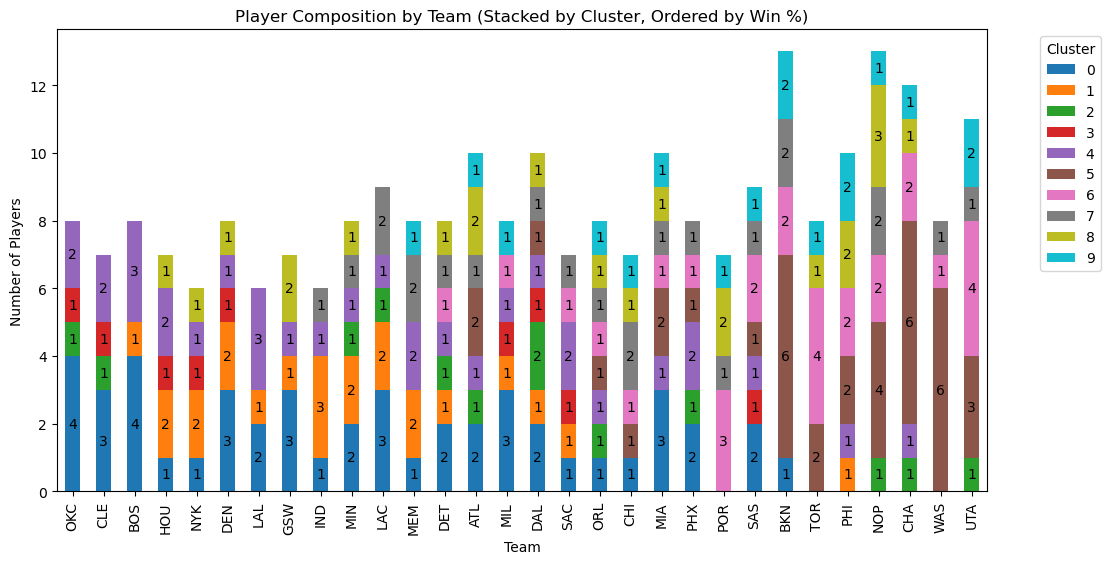

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import LeagueDashPlayerStats

# Fetch LeagueDashPlayerStats
league_stats = LeagueDashPlayerStats()

# Convert the data into a pandas DataFrame
league_stats_df = league_stats.get_data_frames()[0]

# Merge the ordered_df with league_stats_df on 'PLAYER_NAME'
merged_df = pd.merge(ordered_df, league_stats_df, on="PLAYER_NAME", how="left")

# Calculate the average win percentage for teams
team_win_pct = merged_df.groupby('TEAM_ABBREVIATION').agg(
    AVG_WIN_PERCENTAGE=('W_PCT', 'mean')
).reset_index()

# Count players per cluster for each team
composition_df = merged_df.groupby(['TEAM_ABBREVIATION', 'Cluster']).size().reset_index(name='Player_Count')

# Merge win percentage to order teams
composition_df = composition_df.merge(team_win_pct, on='TEAM_ABBREVIATION')

# Sort teams by win percentage **before pivoting**
composition_df = composition_df.sort_values(by="AVG_WIN_PERCENTAGE", ascending=False)

# Pivot after sorting to maintain order
composition_pivot = composition_df.pivot(index='TEAM_ABBREVIATION', columns='Cluster', values='Player_Count').fillna(0)

# **Re-sort index to maintain win percentage order**
composition_pivot = composition_pivot.loc[team_win_pct.sort_values("AVG_WIN_PERCENTAGE", ascending=False)['TEAM_ABBREVIATION']]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
composition_pivot.plot(kind='bar', stacked=True, colormap='tab10', ax=ax)

# Add labels to each section of the bars
for i, team in enumerate(composition_pivot.index):
    bottom = 0  # Keeps track of cumulative height
    for cluster in composition_pivot.columns:
        value = composition_pivot.loc[team, cluster]
        if value > 0:
            ax.text(i, bottom + value / 2, str(int(value)), ha='center', va='center', fontsize=10, color='black')
            bottom += value

# Formatting the chart
plt.title("Player Composition by Team (Stacked by Cluster, Ordered by Win %)")
plt.xlabel("Team")
plt.ylabel("Number of Players")
plt.xticks(rotation=90)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
